# MULTIVARIATE PREDICTION USING MULTIVARIATE FEATURES WITH LSTM SEQ2SEQ
## HERE WE USED: 12h for running the running inference over the next 1h

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from keras.models import Sequential, save_model, load_model
from keras.layers import Bidirectional, LSTM, Dropout, Dense
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_percentage_error
import os
import time
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
from tensorflow.keras.layers import BatchNormalization, ConvLSTM2D, RepeatVector
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from tensorflow.keras.layers import TimeDistributed

import tensorflow as tf
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

models_path = "../saved_models/normal/may2023"
# read dataset may2023
df = pd.read_pickle("../../data/20230319_RTU_Dataset_PPC-Lab/df1.pkl")  

2023-06-12 15:00:58.677050: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-12 15:00:58.832316: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Data Loader Parameters
BATCH_SIZE = 128
BUFFER_SIZE = 100

# LSTM Parameters
EVALUATION_INTERVAL = 200
PATIENCE = 10
PAST_WINDOW_SIZE = 144                    # ----------- 12H
FUTURE_WINDOW_SIZE = 12                   # ----------- 1H
STEP = 3

# Reproducibility
SEED = 13
tf.random.set_seed(SEED)

In [3]:
def create_sequence(dataset, target, window, future):
    x_sequence, y_sequence = [], []
    for index in range(len(dataset) - window - future):
        x_sequence.append(dataset[index: index + window])
        y_sequence.append(target[index + window: index + window + future])
    return (np.asarray(x_sequence), np.asarray(y_sequence))

def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

def multivariate_multioutput_data(dataset, target, start_index, end_index, history_size, target_size, step):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        labels.append(target[i:i+target_size])

    return np.array(data)[:,:,:,np.newaxis,np.newaxis], np.array(labels)[:,:,:,np.newaxis,np.newaxis]

# for x, y in val_data_multi.take(10):
#     multi_step_output_plot(np.squeeze(x[0]), np.squeeze(y[0]), np.squeeze(model.predict(x[0][np.newaxis,:,:,:,:])), df_original_scale)
def multi_step_output_plot(history, true_future, prediction, dataset):
    plt.figure(figsize=(18, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    evaluate = []
    
    for i, (var, c) in enumerate(zip(dataset.columns, ['b','r', 'g'])):
        plt.plot(num_in, np.array(history[:, i]), c, label=var)
        plt.plot(np.arange(num_out)/STEP, np.array(true_future[:,i]), c+'o', markersize=5, alpha=0.5, label=f"True {var.title()}")
        if prediction.any():
            plt.plot(np.arange(num_out)/STEP, np.array(prediction[:,i]), '*', markersize=5, alpha=0.5, label=f"Predicted {var.title()}")
    
    plt.legend(loc='upper left')
    plt.show()
    return evaluate

def create_time_steps(length):
    return list(range(-length, 0))

def evaluate_predictions(predictions_seq, y_test_seq):
    MSE = []
    MAPE = mean_absolute_percentage_error(predictions_seq, y_test_seq)
    for pred in range(len(predictions_seq)):
        mse = mean_squared_error(y_test_seq[pred], predictions_seq[pred])
        MSE.append(mse)
    
    mean_mse = sum(MSE)/len(MSE)
    
    return mean_mse, MAPE

def find_max_error(predictions, y_test, mean_mse, std_mse):
    max_errors = 0
    for pred in range(len(y_test)):
        mse = mean_squared_error(y_test[pred], predictions[pred])
    if mse > mean_mse + std_mse:
        max_errors += 1
    return max_errors

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def build_model_simplified(input_timesteps, output_timesteps, num_links, num_inputs):    
    model = Sequential()
    model.add(BatchNormalization(name = 'batch_norm_0', input_shape = (input_timesteps, num_inputs, 1, 1)))
    model.add(ConvLSTM2D(name ='conv_lstm_1',
                         filters = 64, kernel_size = (10, 1),                       
                         padding = 'same', 
                         return_sequences = False))
    
    model.add(Dropout(0.30, name = 'dropout_1'))
    model.add(BatchNormalization(name = 'batch_norm_1'))

#     model.add(ConvLSTM2D(name ='conv_lstm_2',
#                          filters = 64, kernel_size = (5, 1), 
#                          padding='same',
#                          return_sequences = False))
    
#     model.add(Dropout(0.20, name = 'dropout_2'))
#     model.add(BatchNormalization(name = 'batch_norm_2'))
    
    model.add(Flatten())
    model.add(RepeatVector(output_timesteps))
    model.add(Reshape((output_timesteps, num_inputs, 1, 64)))
    
#     model.add(ConvLSTM2D(name ='conv_lstm_3',
#                          filters = 64, kernel_size = (10, 1), 
#                          padding='same',
#                          return_sequences = True))
    
#     model.add(Dropout(0.20, name = 'dropout_3'))
#     model.add(BatchNormalization(name = 'batch_norm_3'))
    
    model.add(ConvLSTM2D(name ='conv_lstm_4',
                         filters = 64, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = True))
    
    model.add(TimeDistributed(Dense(units=1, name = 'dense_1', activation = 'relu')))
    model.add(Dense(units=1, name = 'dense_2'))

#     optimizer = RMSprop() #lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.9)
#     optimizer = tf.keras.optimizers.Adam(0.1)
    optimizer = tf.keras.optimizers.RMSprop(lr=0.003, clipvalue=1.0)
    model.compile(loss = "mse", optimizer = optimizer, metrics = ['mae', 'mse'])
    return model

def build_model(input_timesteps, output_timesteps, num_links, num_inputs):
    # COPY PASTA
    # https://github.com/niklascp/bus-arrival-convlstm/blob/master/jupyter/ConvLSTM_3x15min_10x64-5x64-10x64-5x64-Comparison.ipynb
    
    model = Sequential()
    model.add(BatchNormalization(name = 'batch_norm_0', input_shape = (input_timesteps, num_inputs, 1, 1)))
    model.add(ConvLSTM2D(name ='conv_lstm_1',
                         filters = 64, kernel_size = (10, 1),                       
                         padding = 'same', 
                         return_sequences = True))
    
    model.add(Dropout(0.30, name = 'dropout_1'))
    model.add(BatchNormalization(name = 'batch_norm_1'))

    model.add(ConvLSTM2D(name ='conv_lstm_2',
                         filters = 64, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = False))
    
    model.add(Dropout(0.20, name = 'dropout_2'))
    model.add(BatchNormalization(name = 'batch_norm_2'))
    
    model.add(Flatten())
    model.add(RepeatVector(output_timesteps))
    model.add(Reshape((output_timesteps, num_inputs, 1, 64)))
    
    model.add(ConvLSTM2D(name ='conv_lstm_3',
                         filters = 64, kernel_size = (10, 1), 
                         padding='same',
                         return_sequences = True))
    
    model.add(Dropout(0.20, name = 'dropout_3'))
    model.add(BatchNormalization(name = 'batch_norm_3'))
    
    model.add(ConvLSTM2D(name ='conv_lstm_4',
                         filters = 64, kernel_size = (5, 1), 
                         padding='same',
                         return_sequences = True))
    
    model.add(TimeDistributed(Dense(units=1, name = 'dense_1', activation = 'relu')))
    model.add(Dense(units=1, name = 'dense_2', activation = 'linear'))

#     optimizer = RMSprop() #lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.9)
#     optimizer = tf.keras.optimizers.Adam(0.1)
    optimizer = tf.keras.optimizers.RMSprop(lr=0.004, clipvalue=1.0)
    model.compile(loss = "mse", optimizer = optimizer, metrics = ['mae', 'mse'])
    return model

def my_mean_absolute_percentage_error(y_true, y_pred):
    error = 0
    for i in range(len(y_true)):
        if y_true[i] != 0:
            error += abs((y_true[i] - y_pred[i]) / y_true[i])
    
    mape = (error / len(y_true)) * 100
    return mape

In [4]:
# Normalizing the values
standard_scaler = preprocessing.StandardScaler()
print(df.head())
scaled_df = standard_scaler.fit_transform(df[['MEM_USAGE', 'CPU_USAGE', 'TEMP']])
print(scaled_df[:10])

training_size = int(len(scaled_df) * 0.8)

print('Scaled_df shape: ' + str(scaled_df.shape))
print('Size of the dataset: %d' % (len(scaled_df)))
print('Size of training: %d' % (training_size))


                         MEM_USAGE  CPU_USAGE    TEMP
time                                                 
2023-01-30 12:11:56.788  35.555417  27.343750  28.687
2023-01-30 12:16:57.191  35.555417   6.367041  28.687
2023-01-30 12:21:57.606  35.555417   7.142857  28.687
2023-01-30 12:26:58.001  35.555417  27.306273  28.687
2023-01-30 12:31:58.396  35.555417   5.639098  28.687
[[ 0.08506655  1.19591608  1.28199992]
 [ 0.08506655 -0.68423674  1.28199992]
 [ 0.08506655 -0.61469997  1.28199992]
 [ 0.08506655  1.192557    1.28199992]
 [ 0.08506655 -0.74948268  1.28199992]
 [ 0.08506655 -0.76244255  1.28199992]
 [ 0.08506655 -0.65738116  1.28199992]
 [ 0.08506655 -0.94465839  1.28199992]
 [ 0.08506655 -0.65292193  1.28199992]
 [ 0.08506655 -0.27458425  1.28199992]]
Scaled_df shape: (2778, 3)
Size of the dataset: 2778
Size of training: 2222


In [5]:
x_train_multi, y_train_multi = multivariate_multioutput_data(scaled_df, scaled_df, 0,
                                                 training_size, PAST_WINDOW_SIZE,
                                                 FUTURE_WINDOW_SIZE, STEP)
x_val_multi, y_val_multi = multivariate_multioutput_data(scaled_df, scaled_df,
                                             training_size, None, PAST_WINDOW_SIZE,
                                             FUTURE_WINDOW_SIZE, STEP)

In [6]:
x_train_multi.shape

(2078, 48, 3, 1, 1)

In [7]:
y_train_multi.shape

(2078, 12, 3, 1, 1)

In [8]:
x_val_multi.shape

(400, 48, 3, 1, 1)

In [9]:
y_val_multi.shape

(400, 12, 3, 1, 1)

In [10]:
BATCH_SIZE = 128

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

2023-06-12 15:01:10.256600: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-12 15:01:10.282647: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-12 15:01:10.282916: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [11]:
EPOCHS = 30
steps_per_epoch = 350
validation_steps = 500

modelstart = time.time()
early_stopping = EarlyStopping(monitor='val_loss', patience = PATIENCE, restore_best_weights=True)
model = build_model(x_train_multi.shape[1], FUTURE_WINDOW_SIZE, y_train_multi.shape[2], x_train_multi.shape[2])
print(model.summary())

# Train
print("\nTRAIN MODEL...")
history = model.fit(train_data_multi,
                    epochs = EPOCHS,
                    validation_data=val_data_multi,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    verbose=1,
                    callbacks=[early_stopping])
model.save('multi-output-timesteps.h5')
print("\nModel Runtime: %0.2f Minutes"%((time.time() - modelstart)/60))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_norm_0 (BatchNormaliz  (None, 48, 3, 1, 1)      4         
 ation)                                                          
                                                                 
 conv_lstm_1 (ConvLSTM2D)    (None, 48, 3, 1, 64)      166656    
                                                                 
 dropout_1 (Dropout)         (None, 48, 3, 1, 64)      0         
                                                                 
 batch_norm_1 (BatchNormaliz  (None, 48, 3, 1, 64)     256       
 ation)                                                          
                                                                 
 conv_lstm_2 (ConvLSTM2D)    (None, 3, 1, 64)          164096    
                                                                 
 dropout_2 (Dropout)         (None, 3, 1, 64)          0

2023-06-12 15:01:14.299463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [2078,12,3,1,1]
	 [[{{node Placeholder/_1}}]]
2023-06-12 15:01:17.834141: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ingradient_tape/sequential/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-06-12 15:01:19.868510: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-06-12 15:01:21.279683: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fd19ddc8a20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-12 15:01:21.279699: I tensorflow/compiler/xla/

350/350 [==============================] - ETA: 0s - loss: 0.4820 - mae: 0.4448 - mse: 0.4820

2023-06-12 15:02:29.227622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [400,12,3,1,1]
	 [[{{node Placeholder/_1}}]]


350/350 [==============================] - 101s 263ms/step - loss: 0.4820 - mae: 0.4448 - mse: 0.4820 - val_loss: 2.4133 - val_mae: 0.8059 - val_mse: 2.4133
Epoch 2/30
350/350 [==============================] - 91s 261ms/step - loss: 0.4627 - mae: 0.4263 - mse: 0.4627 - val_loss: 2.4230 - val_mae: 0.8145 - val_mse: 2.4230
Epoch 3/30
350/350 [==============================] - 90s 257ms/step - loss: 0.4373 - mae: 0.3777 - mse: 0.4373 - val_loss: 2.3404 - val_mae: 0.7196 - val_mse: 2.3404
Epoch 4/30
350/350 [==============================] - 92s 262ms/step - loss: 0.4045 - mae: 0.3613 - mse: 0.4045 - val_loss: 2.2323 - val_mae: 0.6843 - val_mse: 2.2323
Epoch 5/30
350/350 [==============================] - 94s 268ms/step - loss: 0.3736 - mae: 0.3433 - mse: 0.3736 - val_loss: 2.1614 - val_mae: 0.6303 - val_mse: 2.1614
Epoch 6/30
350/350 [==============================] - 93s 266ms/step - loss: 0.3462 - mae: 0.3225 - mse: 0.3462 - val_loss: 2.1099 - val_mae: 0.6203 - val_mse: 2.1099
Epoch 7/

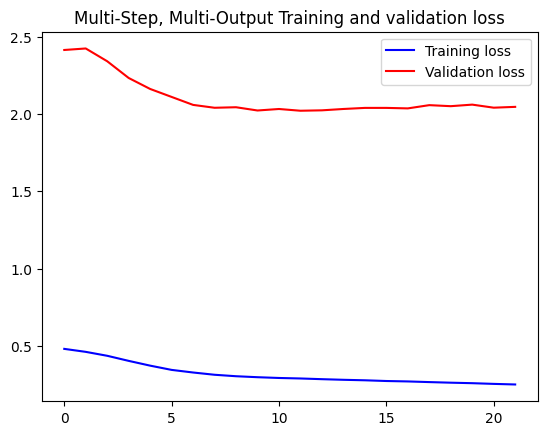

In [12]:
plot_train_history(history, 'Multi-Step, Multi-Output Training and validation loss')

2023-06-12 16:31:52.342821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [400,12,3,1,1]
	 [[{{node Placeholder/_1}}]]


1/1 [==============================] - 1s 525ms/step


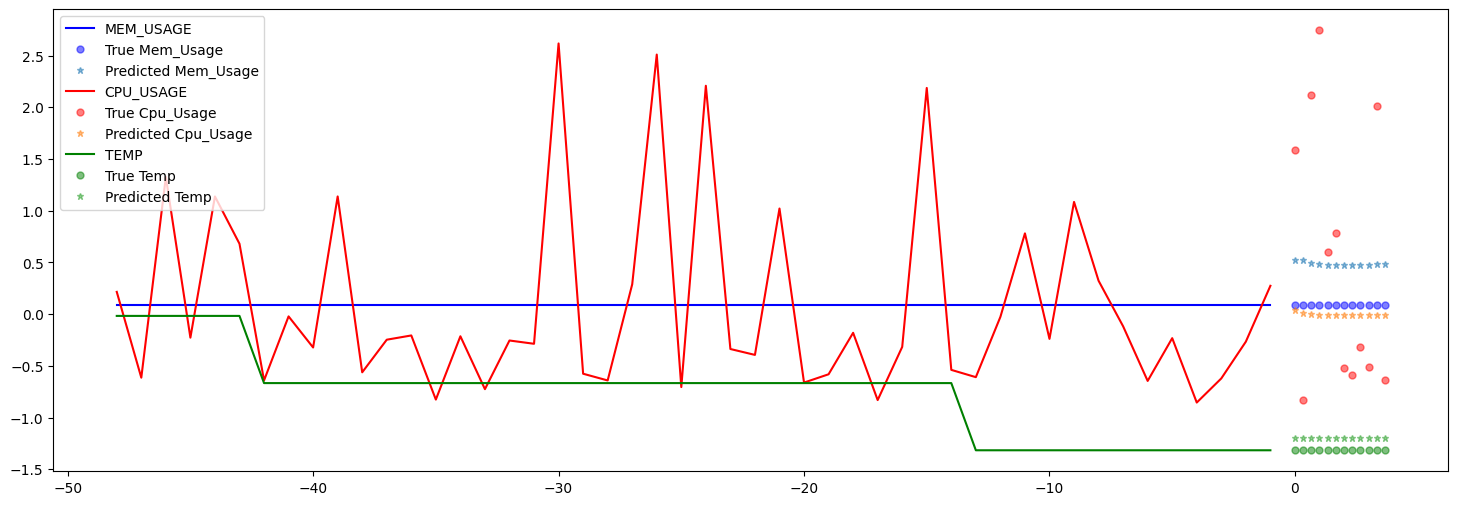

1/1 [==============================] - 0s 51ms/step


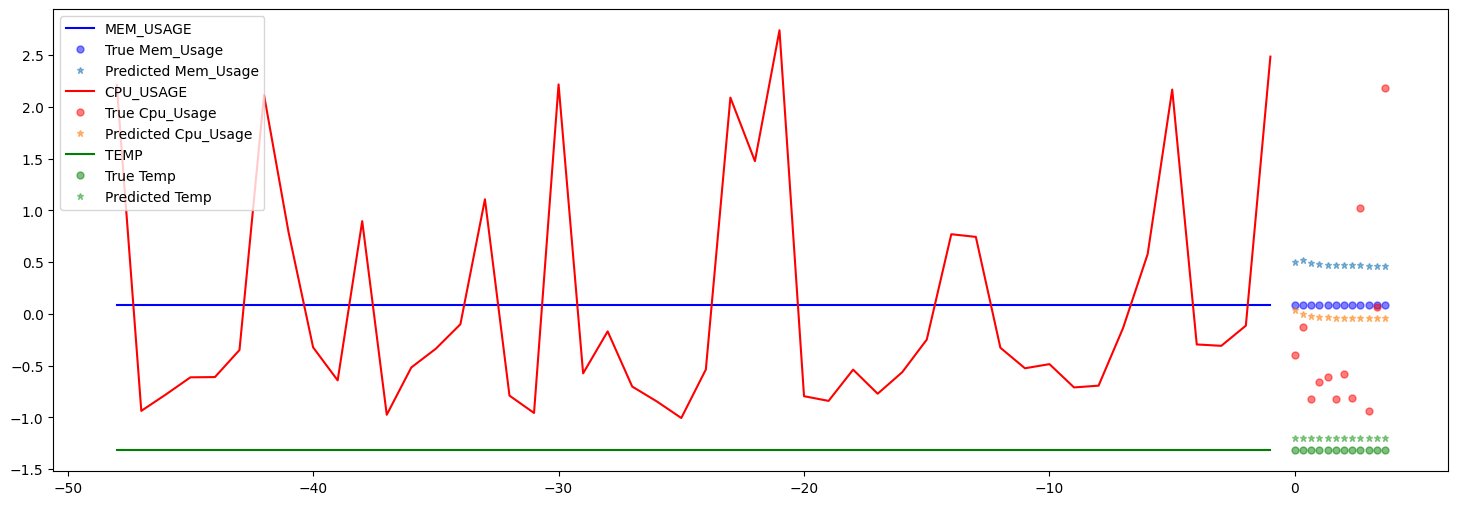

1/1 [==============================] - 0s 48ms/step


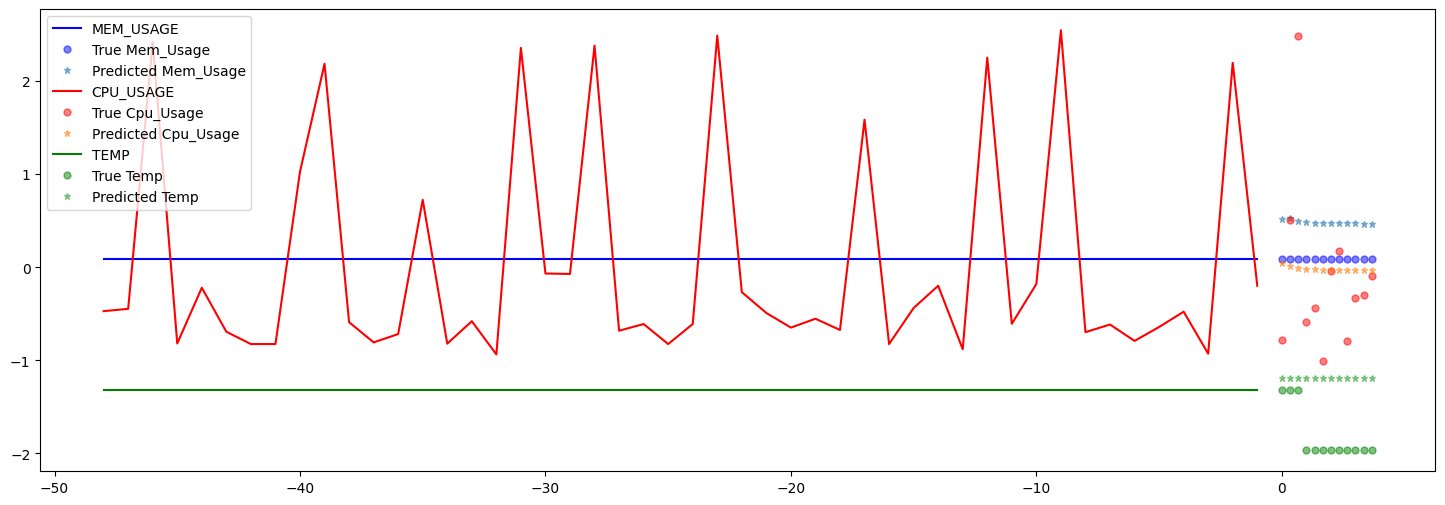

1/1 [==============================] - 0s 48ms/step


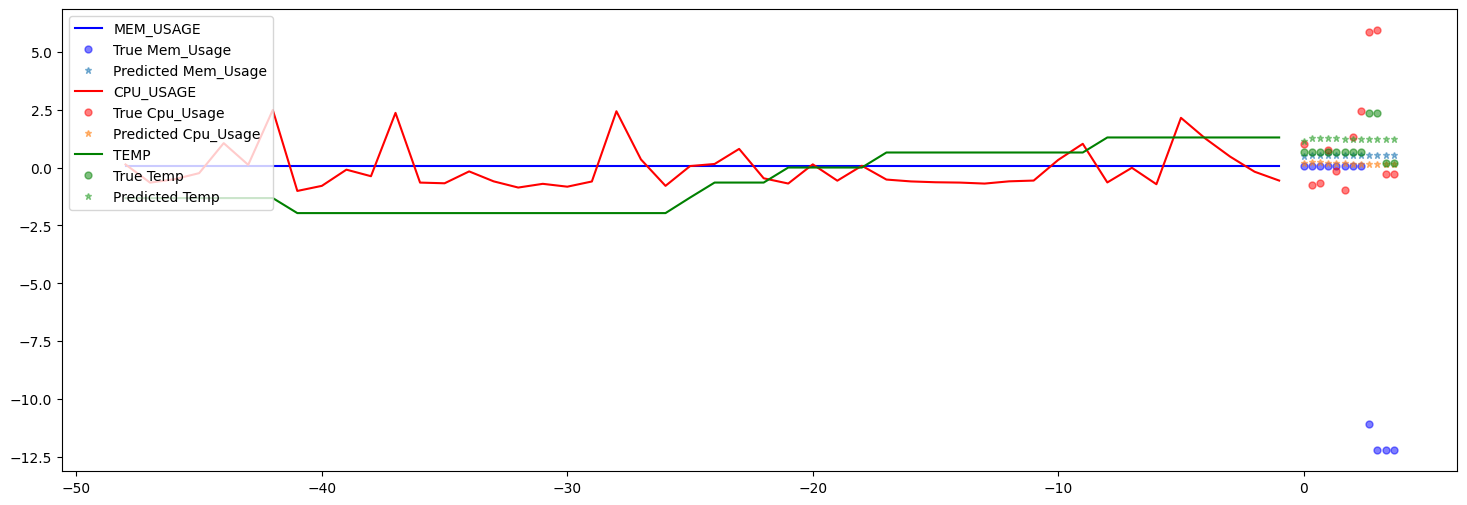

1/1 [==============================] - 0s 48ms/step


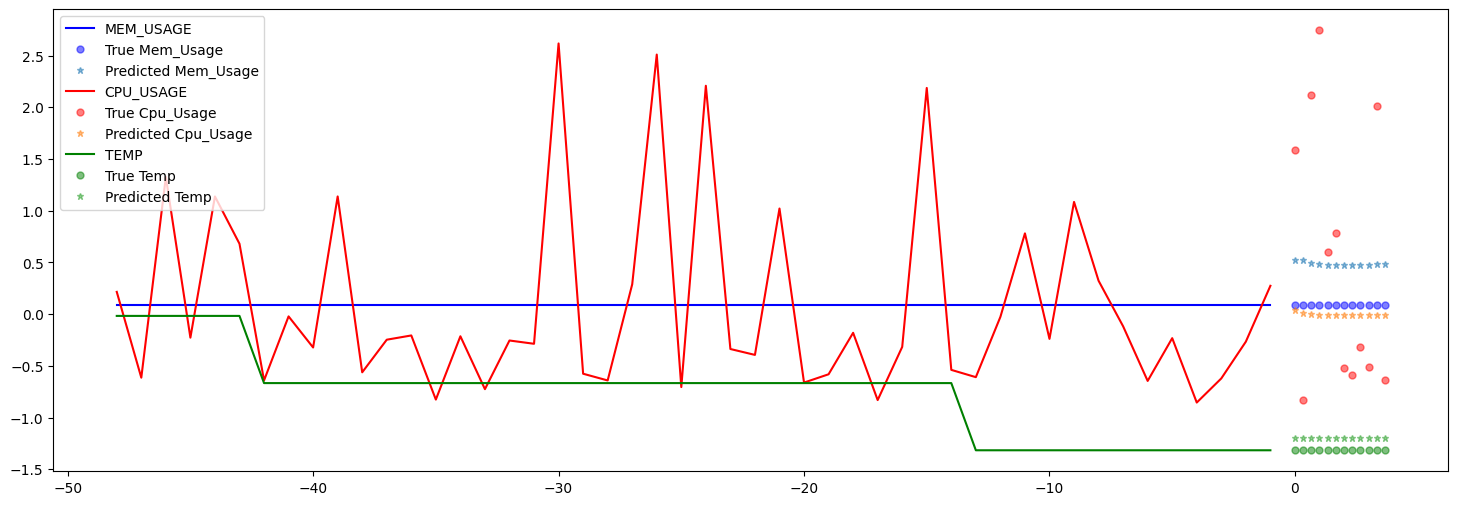

1/1 [==============================] - 0s 48ms/step


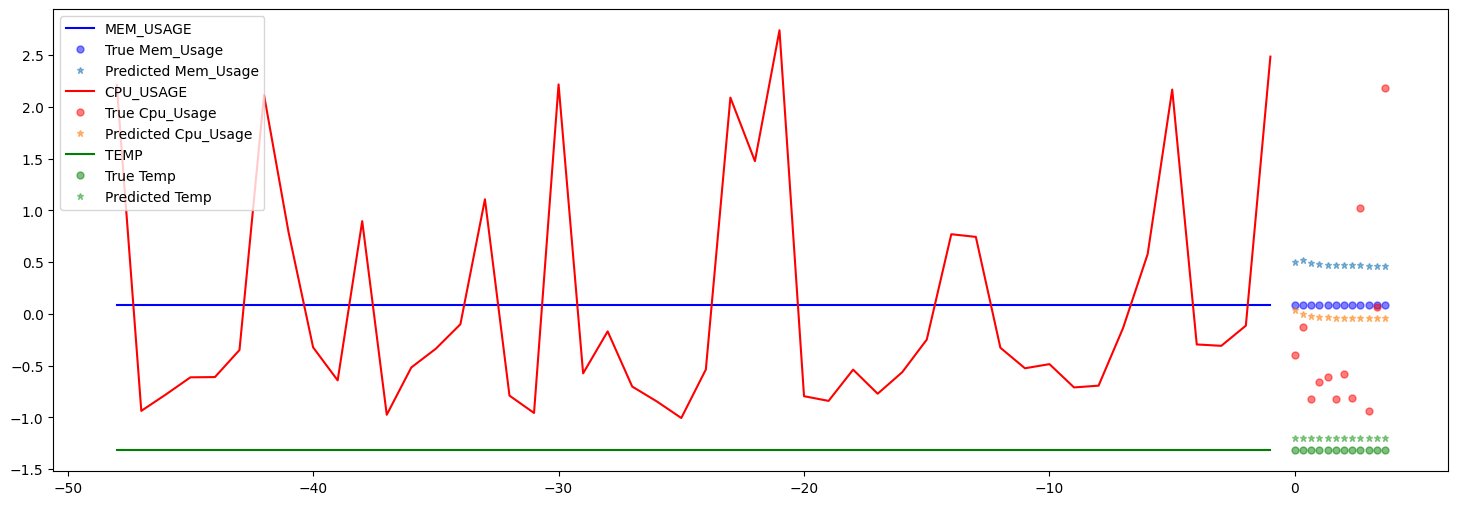

1/1 [==============================] - 0s 48ms/step


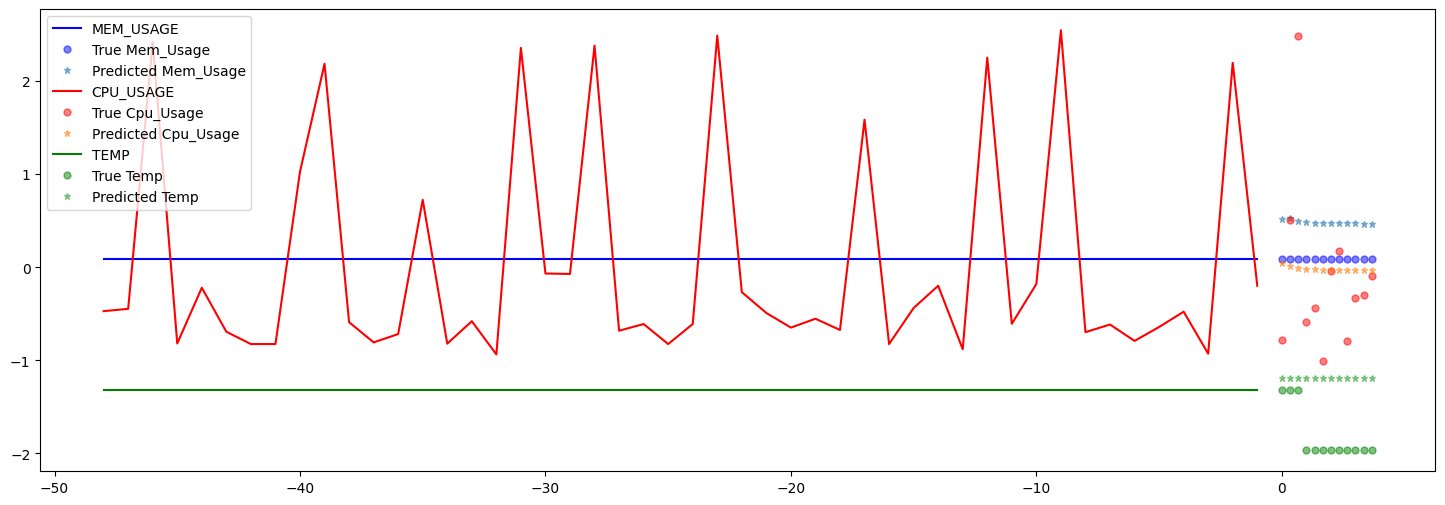

1/1 [==============================] - 0s 48ms/step


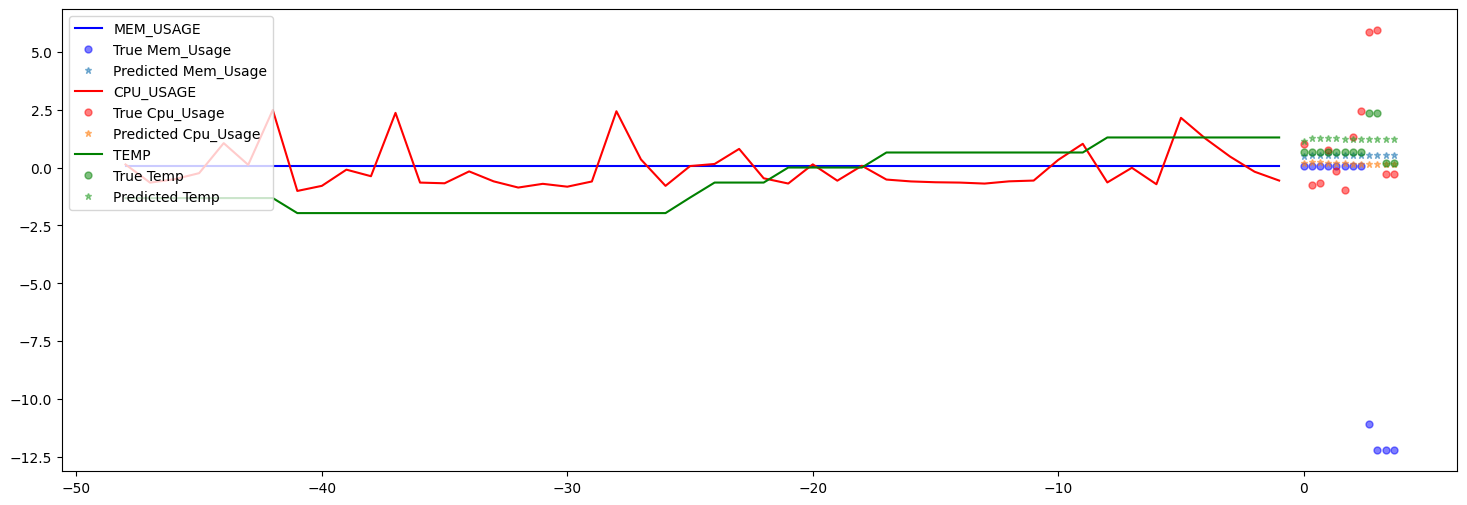

1/1 [==============================] - 0s 48ms/step


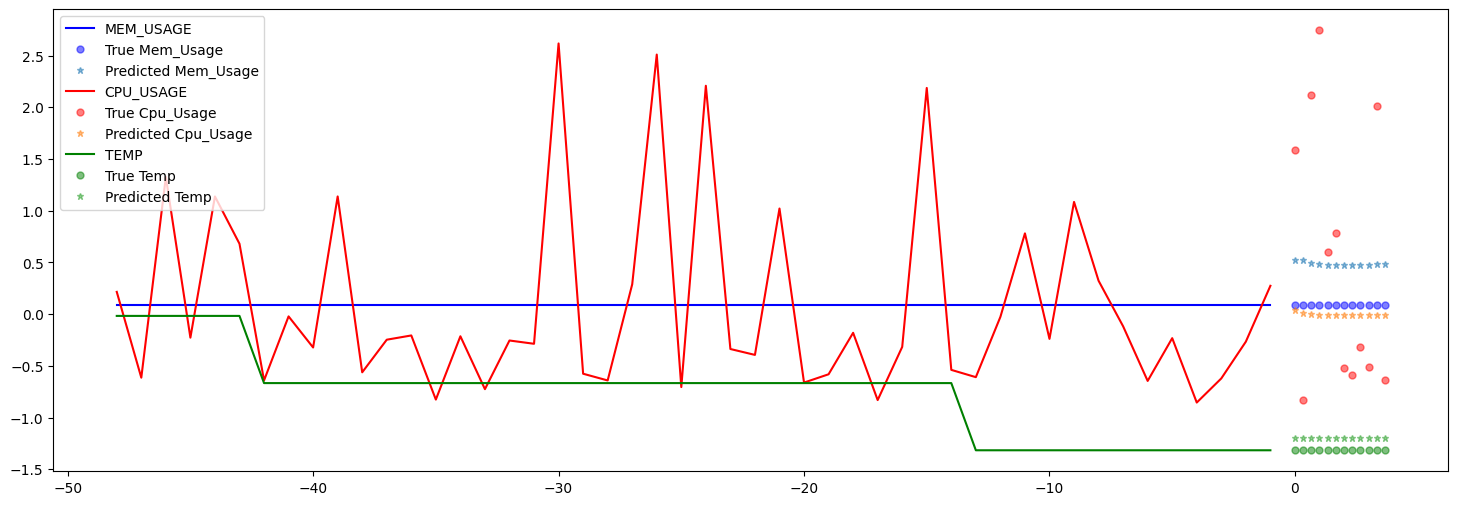

1/1 [==============================] - 0s 48ms/step


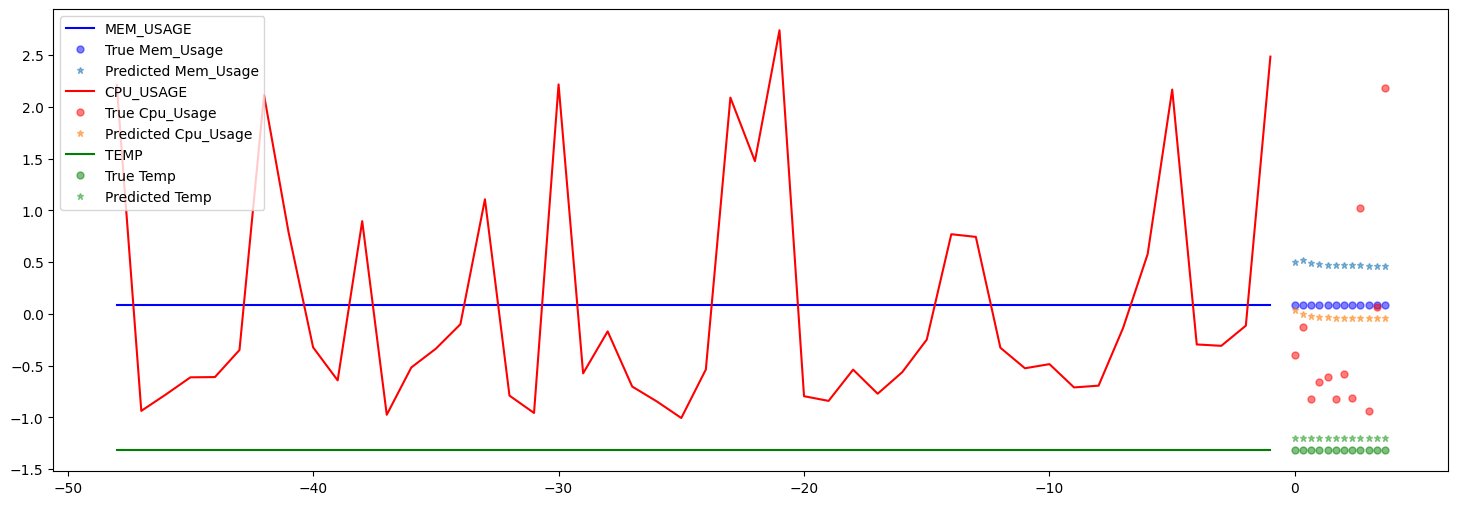

In [13]:
from tensorflow import keras
model = keras.models.load_model("./best_multi_multi_lstm.h5")

column_names = ['MEM_USAGE', 'CPU_USAGE', 'TEMP']
df_original_scale = pd.DataFrame(data=scaled_df, columns=column_names)

for x, y in val_data_multi.take(10):
    multi_step_output_plot(np.squeeze(x[0]), np.squeeze(y[0]), np.squeeze(model.predict(x[0][np.newaxis,:,:,:,:])), df_original_scale)

# EVALUATE PERFORMANCE

In [14]:
import tensorflow as tf
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().batch(BATCH_SIZE)
val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE)

train_data_multi

<_BatchDataset element_spec=(TensorSpec(shape=(None, 48, 3, 1, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 12, 3, 1, 1), dtype=tf.float64, name=None))>

In [15]:
history_mems = []
history_cpus = []
history_temps = []

predicted_mems = []
predicted_cpus = []
predicted_temps = []

original_mems = []
original_cpus = []
original_temps = []

for x, y in train_data_multi:
    hx_mem = np.squeeze(x[0])[:,0]
    hx_cpu = np.squeeze(x[0])[:,1]
    hx_temp = np.squeeze(x[0])[:,2]
    
    history_mems.append(hx_mem)
    history_cpus.append(hx_cpu)
    history_temps.append(hx_temp)
    

for x, y in val_data_multi:
    
    prediction = np.squeeze(model.predict(x[0][np.newaxis,:,:,:,:], verbose = 0))
    pred_mems = prediction[:,0]
    pred_cpus = prediction[:,1]
    pred_temps = prediction[:,2]
    ori_mems = np.squeeze(y[0])[:,0]
    ori_cpus = np.squeeze(y[0])[:,1]    
    ori_temps = np.squeeze(y[0])[:,2]   
    
    predicted_mems.append(pred_mems)
    original_mems.append(ori_mems)
    
    predicted_cpus.append(pred_cpus)
    original_cpus.append(ori_cpus)
    
    predicted_temps.append(pred_temps)
    original_temps.append(ori_temps)
    
    

2023-06-12 16:32:01.534213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [2078,12,3,1,1]
	 [[{{node Placeholder/_1}}]]
2023-06-12 16:32:01.584649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [400,12,3,1,1]
	 [[{{node Placeholder/_1}}]]


In [16]:
history_mem_usage = np.concatenate(history_mems, axis=0)
history_cpu_usage = np.concatenate(history_cpus, axis=0)
history_temperatures = np.concatenate(history_temps, axis=0)

predicted_mem_usage = np.concatenate(predicted_mems, axis=0)
predicted_cpu_usage = np.concatenate(predicted_cpus, axis=0)
predicted_temperatures = np.concatenate(predicted_temps, axis=0)

original_mem_usage = np.concatenate(original_mems, axis=0)
original_cpu_usage = np.concatenate(original_cpus, axis=0)
original_temperatures = np.concatenate(original_temps, axis=0)

## Error for MEMORY USAGE

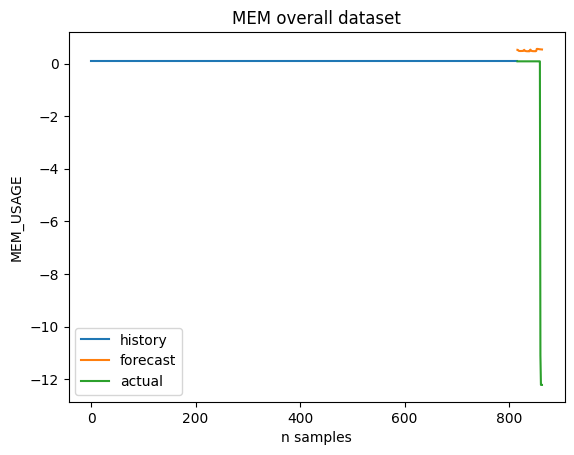

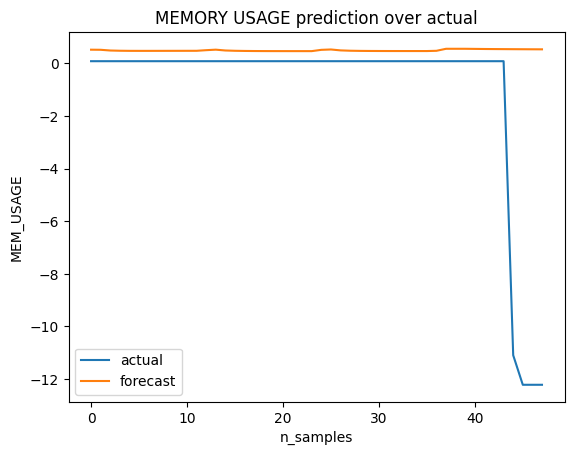

In [17]:
plt.title("MEM overall dataset") 
plt.xlabel("n samples") 
plt.ylabel("MEM_USAGE") 
plt.plot(range(len(history_mem_usage)),history_mem_usage, label="history") 
plt.plot(range(len(history_mem_usage), len(history_mem_usage) + len(predicted_mem_usage)),predicted_mem_usage, label="forecast") 
plt.plot(range(len(history_mem_usage), len(history_mem_usage) + len(predicted_mem_usage)),original_mem_usage, label="actual") 

plt.legend()
plt.show()


x = range(len(predicted_mem_usage))
plt.title("MEMORY USAGE prediction over actual") 
plt.xlabel("n_samples") 
plt.ylabel("MEM_USAGE") 
plt.plot(x,original_mem_usage, label="actual") 
plt.plot(x,predicted_mem_usage, label="forecast") 
plt.legend()
plt.show()


In [18]:
my_mean_absolute_percentage_error(original_mem_usage, predicted_mem_usage)

449.66190230305784

## Error for CPU USAGE

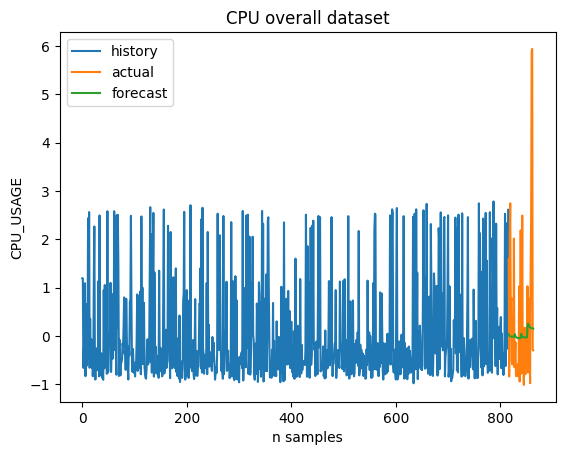

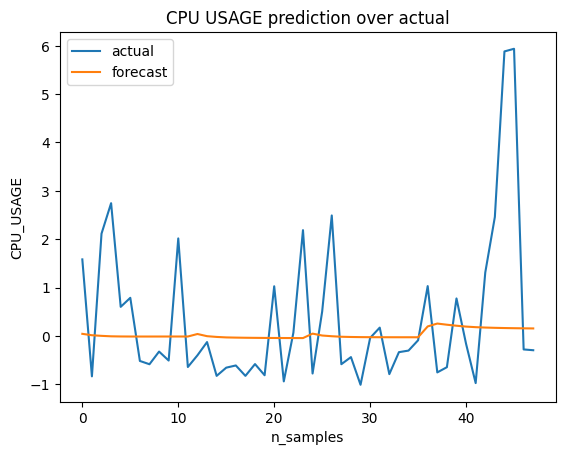

In [19]:
plt.title("CPU overall dataset") 
plt.xlabel("n samples") 
plt.ylabel("CPU_USAGE") 
plt.plot(range(len(history_cpu_usage)),history_cpu_usage, label="history") 
plt.plot(range(len(history_cpu_usage), len(history_cpu_usage) + len(predicted_cpu_usage)),original_cpu_usage, label="actual") 
plt.plot(range(len(history_cpu_usage), len(history_cpu_usage) + len(predicted_cpu_usage)),predicted_cpu_usage, label="forecast")

plt.legend()
plt.show()

x = range(len(predicted_mem_usage))
plt.title("CPU USAGE prediction over actual") 
plt.xlabel("n_samples") 
plt.ylabel("CPU_USAGE") 
plt.plot(x,original_cpu_usage, label="actual") 
plt.plot(x,predicted_cpu_usage, label="forecast") 
plt.legend()
plt.show()


In [20]:
my_mean_absolute_percentage_error(original_cpu_usage, predicted_cpu_usage)

103.65317594999493

## Error for temperature

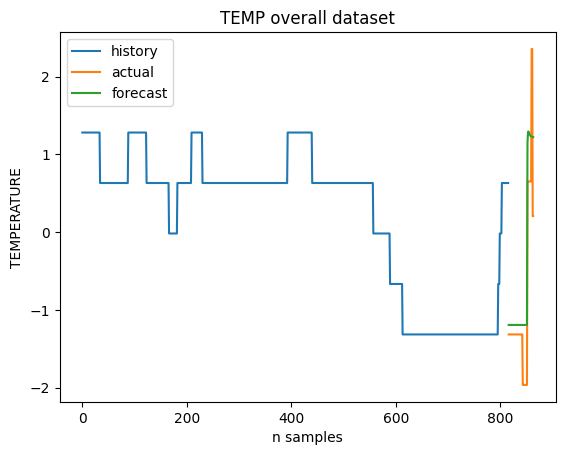

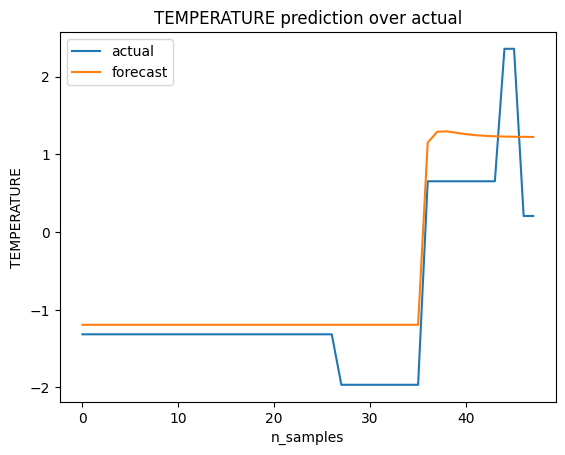

In [21]:
plt.title("TEMP overall dataset") 
plt.xlabel("n samples") 
plt.ylabel("TEMPERATURE") 
plt.plot(range(len(history_temperatures)),history_temperatures, label="history") 
plt.plot(range(len(history_temperatures), len(history_temperatures) + len(predicted_temperatures)),original_temperatures, label="actual") 
plt.plot(range(len(history_temperatures), len(history_temperatures) + len(predicted_temperatures)),predicted_temperatures, label="forecast")

plt.legend()
plt.show()

x = range(len(predicted_mem_usage))
plt.title("TEMPERATURE prediction over actual") 
plt.xlabel("n_samples") 
plt.ylabel("TEMPERATURE") 
plt.plot(x,original_temperatures, label="actual") 
plt.plot(x,predicted_temperatures, label="forecast") 
plt.legend()
plt.show()


In [22]:
my_mean_absolute_percentage_error(original_temperatures, predicted_temperatures)

50.36449627038371

---------------------------------------------

#### Overall the only metrics which seems to reach a reasonable accuracy is the temperature with 50% of accuracy (1-MAPE), but the model lacks any understanding of the other metrics, I dont consider this a reliable result
